# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [29]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

In [30]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
from matplotlib import pyplot as plt

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

# Las siguientes dos líneas para ejecutar código 1.x en TensorFlow 2.x (agregado por golivetti)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [31]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
# base_image_path = Path("/Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
# style_reference_image_path = Path("/Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/La_noche_estrellada1.jpg")
result_prefix = Path("/content/output")
# result_prefix = Path("/Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/content/output")
iterations = 100

# Arquitectura de Style Transfer según paper

![Arquitectura NST](nst_architecture.png)

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

La función de costo final (loss final) que se minimiza durante la sintetización de la imagen de salida es una suma ponderada de tres términos (losses): Content Loss (función de costo de Contenido), Style Loss (función de costo de Estilo) y Total Variation Loss (función de costo de regularización).
A cada uno de los términos se le asigna un peso (coeficiente) de acuerdo al resultado final que se pretende en la imagen a sintetizar (imagen de salida).

Total Variation Weight (TVW): es la ponderación que se le da a la "Total Variation Loss" que opera directamente sobre los pixeles de la imagen de salida para suavizarla (continuidad espacial) y que no sea tan ruidosa (evitando resultados excesivamente pixelados). La "Total Variation Loss" actúa como un término de regularización, por lo tanto este coeficiente "regula" su contribución.

Style Weight: es la ponderación que se le da al estilo en la imagen de salida (β o Beta en el paper de referencia). Es decir, cuánto de la imagen que aporta el estilo (texturas, colores, curvaturas, etc) aparecerá en la imagen de salida generada.

Content Weight: es la ponderación que se le da al contenido en la imagen de salida (α o Alfa en el paper de referencia). Es decir, cuánto de la imagen que aporta el contenido aparecerá en la imagen de salida generada.

Resumiendo, ajustando los valores de los coeficientes α y β se podrá lograr que el contenido o el estilo, respectivamente, sean más reconocibles en la imagen de salida generada. Estos pesos definen cuánto impacto tendrá el estilo o el contenido en la loss final.
Adicionalmente, α y β ayudan a ajustar las escalas de las funciones de costo de Contenido y de Estilo ya que, por la forma de cálculo, están en diferentes escalas. 

α, β y TVW, por lo tanto, son hiperparámetros.

In [32]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

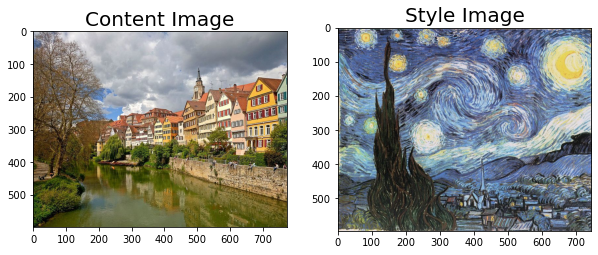

In [33]:
# Celda agregada por golivetti para graficar imagen de contenido e imagen de estilo

plt.figure(figsize=(10,10))

content = load_img(base_image_path)
style = load_img(style_reference_image_path)

plt.subplot(1, 2, 1)
plt.title("Content Image", fontsize=20)
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.title("Style Image", fontsize=20)
plt.imshow(style)

In [34]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

La siguiente celda define una función auxiliar para cargar y pre-procesar las imágenes de contenido y de estilo antes de ingresarlas a la VGG19. Carga una imagen, la redimensiona, la convierte a un Numpy array.

En cuanto a las dos últimas líneas antes del return:
1) La entrada a la CNN debe ser un array 4D con el formato (batch_size, height, width, depth), donde la primera dimensión representa el tamaño del batch y las otras tres dimensiones representan las dimensiones de la imagen (alto, ancho, profundidad). Con np.expand_dims(img, axis=0) se agrega la primera dimensión (axis=0) correspondiente al batch_size.

2) La red VGG está entrenada a partir de imágenes que tienen cada canal de color normalizado con la media (=[103.939, 116.779, 123.68]) y con los canales en orden BGR.
Por lo tanto, antes de ingresar las imágenes al modelo hay que llamar vgg19.preprocess_input que convierte las imágenes de RGB a BGR, luego centra en cero (normaliza) cada canal de color con respecto al dataset de ImageNet, y sin escalar (fuente: https://keras.io/api/applications/vgg/#vgg19-function).

In [35]:
# La red VGG está entrenada a partir de imágenes que tienen cada canal de color normalizado con 
# la media (=[103.939, 116.779, 123.68]) y con los canales en orden BGR.
# Para VGG19, llamar tf.keras.applications.vgg19.preprocess_input para convertir las imágenes de 
# RGB a BGR, luego centrar en cero (normaliza) cada canal de color con respecto al dataset de 
# ImageNet, y sin escalar.

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    # 
    # La entrada a la CNN debe ser un array 4D con el formato (batch_size, height, width, depth)
    # np.expand_dims(img, axis=0) agrega la primera dimensión (axis=0) para el batch_size.
    img = np.expand_dims(img, axis=0)
    # Preprocesa un tensor o Numpy array
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Relación con la celda anterior: invierte la transformación que realiza vgg19.prepocess_input.

Convierte la imagen procesada a su formato original para posterior visualización.
Desnormaliza cada canal de color de la imagen con el valor medio de pixeles del dataset de ImageNet.
Convierte la imagen de BGR a RGB.
Hace un clip para mantener los valores de la imagen entre 0 y 255.

In [36]:
def deprocess_image(x):
    # Convierte tensor en una imagen valida para visualizar
    x = x.reshape((img_nrows, img_ncols, 3))
    # Desnormaliza eliminando centrado en cero por valor medio pixeles según ImageNet
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    # Como la imagen optimizada puede tomar valores entre −∞  and  ∞ , se hace clip para mantener
    # los valores de la imagen en el rango 0-255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [37]:
# Obtener tensores a partir de las imágenes a procesar
# K.variable convierte un numpy array en un tensor 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [38]:
# Tensor para la imagen de salida generada
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [39]:
# Combina los tensores de imágenes (contenido, estilo y el placeholder para la imagen de salida)
# a lo largo del eje 0 resultando en un tensor Keras 4D con la forma [3, altura, ancho, canales]
# para luego ingresar a la VGG19 con un batch de 3 imágenes.

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# Arquitectura de red VGG19

![VGG19](VGG19.png)

In [40]:
# Instancia el modelo VGG19 con el batch de 3 imágenes como entrada.
# El modelo se carga con los pesos pre-entrenados con el dataset ImageNet.
# "include_top=False": no se importan las 3 capas FCN superiores.

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# Crea un diccionario con "key"=nombre capa y "value"=salida de capa

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(model.summary())

Model loaded.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(3, 400, 517, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 517, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 517, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 258, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 258, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 258, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 129, 128)

# 4) En las siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

Respuesta:

##### Matriz de Gram
Es una forma de representar teóricamente la información del estilo de una imagen. La información de estilo se mide como la cantidad de correlación existente entre los mapas de características (feature maps) de una capa convolucional (layer) determinada, donde la posición de la capa (una capa más profunda o una capa menos profunda) determina la escala espacial en la que se combina ese estilo.
Se calcula como el producto punto de los feature maps aplanados (vectorizados) de una capa determinada (el producto punto da una medida de la correlación entre los features de una capa, es decir una medida de similitud). Cuanto menor es el producto, más diferentes son las características o features (menor es la correlación de las dos características) y cuanto mayor es el producto, más correlacionadas están las características o features (ocurrencia conjunta).
Cada elemento de la matriz de Gram representa la correlación existente entre dos feature maps (ver imagen en próxima celda).
Para extraer la información de estilo de la red VGG, se utilizan varias o todas las capas convolucionales de la CNN. Al incluir las correlaciones entre características (feature maps) de varias capas se captura información de estilo de la imagen al mismo tiempo que se ignora la información de contenido.

La matriz de Gram se usa para medir el grado de correlación entre los mapas de características (feature maps) de una capa que luego actúa como medida del estilo de una imagen.
Dos imágenes tendrán el mismo estilo en una capa, si las correlaciones entre sus feature maps de esa capa son iguales, es decir si las matrices de Gram para esa capa son iguales.

Se permutan las dimensiones de x para poner como primera dimensión del tensor a los Channels (feature maps) de la capa convolucional, de tal forma que luego aplanándolo con "K.batch_flatten" se obtenga un tensor 2D (donde cada fila corresponde a un Channel de la capa convolucional y representa un feature map) que multiplicado por su transpuesta da la matriz de Gram.
Esto se hace porque es computacionalmente eficiente simplificando el cálculo de la matriz de Gram.

# Ejemplo de cálculo de la Matriz de Gram

![GramMatrix](style_matrix.png)

In [41]:
# Función auxiliar para calcular la matriz de Gram

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Respuesta:

La función de costo (loss final) utilizada en el algoritmo de transferencia de estilo consta de tres términos: la función de costo de contenido (content loss) que hace que la imagen generada y la imagen de contenido tengan características de contenido similares; la función de costo de estilo (style loss) que hace que la imagen generada y la imagen de estilo tengan características de estilo similares; y la función de costo "Total Variation" que ayuda a reducir el ruido en la imagen generada.

Style Loss: mide la diferencia de estilo entre la imagen generada y la imagen cuyo estilo se toma como referencia.
Se calcula como una suma ponderada de los errores cuadráticos entre las matrices de Gram (calculados para diferentes capas convolucionales) de la imagen generada y de la imagen de estilo de referencia.
Como la información de estilo se extrae de varias capas convolucionales (se utilizan varias capas en el cálculo de la Style Loss), para cada capa utilizada se calcula una "style loss de capa" como el error cuadrático (distancia) entre las matrices de Gram de las dos imágenes (generada y de estilo) para esa capa individual, y luego se hace la suma ponderada de esos errores ("style loss de capa") para todas las capas utilizadas.

Content Loss: mide la diferencia de contenido entre la imagen generada y la imagen cuyo contenido se toma como referencia. Es la distancia entre mapas de activaciones (de una capa profunda) de la imagen generada y de la imagen de contenido.
Se calcula como el error cuadrático entre los feature maps (mapas de activaciones) de la imagen generada y de la imagen de contenido de referencia (features extraídas de una capa profunda). Normalmente, la información de contenido se extrae de una sola capa convolucional (capas altas o más profundas que poseen información más compleja).

Total Variation Loss: actúa como un término de regularización, operando sobre los pixeles de la imagen generada para que la misma no aparezca pixelada (ruidosa). Esto se logra comparando con los pixeles cercanos (vecinos) y minimizando su diferencia.

# Transferencia de estilo con CNN
##### Las líneas sólidas muestran la dirección del forward propagation.
##### Las líneas de trazos muestran la dirección del back propagation.

![CNN_based_Style_Transfer](CNN_based_Style_Transfer.png)

In [42]:
# Información de estilo: se mide como la cantidad de correlación presente entre feature maps por capa
# Se usa Gram Matrix

# style = features imagen de estilo
# combination = features imagen de salida generada

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [43]:
# base = features imagen de contenido
# combination = features imagen de salida generada

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [44]:
# Se compara cada pixel con su vecino hacia la izquierda y hacia abajo
# Tratando de minimizar esa diferencia entre pixeles, se mejora la continuidad espacial de la imagen

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [45]:
# Armamos la loss total
loss = K.variable(0.0)
# Define capa de la cual se extraerá la información de CONTENIDO (feature maps).
# Capa a usar para la Content Loss
layer_features = outputs_dict['block5_conv2']
#
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

# Define capas de las cuales se extraerá la información de ESTILO (capas a usar para Style Loss)
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    # Según la cantidad de capas usadas para Style Loss, se toma el promedio
    loss = loss + (style_weight / len(feature_layers)) * sl

# Arma loss final agregando el término TOTAL VARIATION LOSS
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [46]:
# Obtiene los gradientes de la loss con respecto a la imagen generada

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# Funcion para obtener los valores actuales de loss y gradiente
# Devuelve: tupla de (loss, gradientes)
# loss: loss entre imagen de contenido, imagen de estilo e imagen generada
# gradientes: gradientes de imagen generada respecto a la loss

f_outputs = K.function([combination_image], outputs)

# Detalle algoritmo Style Transfer del paper Gatys y otros

![Gatys_StyleTransfer](Gatys_Style_Transfer_Algorithm.png)

In [47]:
# Celda agregada por golivetti para graficar la evolución de la loss
loss_history = []

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

#### Propósito de las siguientes tres celdas
Celda 1: función auxiliar que devuelve los valores de loss y gradientes a partir de una imagen de entrada.

Celda 2 (class Evaluator): Calcula el valor de la loss y los gradientes en una sola pasada, y los devuelve a través de dos funciones separadas, "loss" y "grads". 
El algoritmo de optimización L-BFGS de SciPy requiere que se le pase el valor de loss y de gradientes como dos parámetros (funciones) separados. Como calcularlos por separado sería computacionalmente ineficiente, entonces se implementa la clase "Evaluator" para contrarrestar esta limitación. 

Celda 3: Usa el algoritmo L-BFGS de SciPy sobre los pixeles de la imagen generada para minimizar la loss total y ejecutar el proceso de transferencia de estilo. También guarda la imagen actual generada en cada iteración del algoritmo (1 iteración = 20 pasos de gradient descent).

#### Función fmin_l_bfgs_b

La función fmin_l_bfgs_b ejecuta la optimización (usando el algoritmo L-BFGS de SciPy) para minimizar la loss total encontrando el valor óptimo de los pixeles de la imagen generada. Minimizando la loss no se busca aprender los parámetros (pesos) óptimos de la red (los cuales no se modifican), sino que se busca aprender una imagen.

#### Diferencias con la implementacion del paper

##### En cuanto al algoritmo de optimización por gradient descent:

1) En el paper de Gatys se menciona que se ejecuta el gradient descent a partir de una imagen aleatoria (ruido blanco o white noise image) que durante el aprendizaje se va modificando para que su contenido sea similar a la imagen de contenido y su estilo similar a la imagen de estilo.
En la presente implementación en esta notebook, se ejecuta el gradient descent a partir de la propia imagen de contenido a la cual se le desea aplicar el estilo de otra (esto logra resultados estéticamente más agradables y una convergencia más rápida del algoritmo).

##### Otras diferencias observadas con la implementación del paper:

1) En el paper de Gatys al menos no se menciona el uso del término regularizador "Total Variation Loss", por lo cual se asume que su ponderación habría sido 0. En la presente implementación en esta notebook, en la función de costo final (loss final) se agrega la "Total Variation Loss" para eliminar ruido (pixelado) en la imagen de salida.

2) En el paper de Gatys, en la red VGG19 se reemplazaron las capas "Max Pooling" por "Average Pooling" porque mejoraba la convergencia del gradiente (página 9 del paper). En la presente implementación se mantienen las capas "Max Pooling" como se puede observar en el model.summary()

3) En el paper de Gatys se usa como referencia para el contenido la capa convolucional "block4_conv2" (página 12 del paper), mientras que en la presente implementación se usa la capa convolucional "block5_conv2" y por lo tanto esta representación es más abstracta.

#### Alternativa

En cuanto a optimización, se podrían utilizar otros algoritmos como Adam o SGD, aunque no dejan de ser métodos iterativos de optimización que requieren realizar pasadas forward y backward a través de la CNN lo que hace lento el proceso de convergencia.

Un método alternativo de transferencia de estilo podría ser utilizando una arquitectura diferente donde la imagen de entrada pase a través de una red "Image Transformation Net" (con encoder-decoder) y la salida de esta red junto con las imágenes de contenido y estilo se alimenten a una red pre-entrenada (VGG por ejemplo) que hace las veces de "loss network" usando el concepto de "perceptual loss" para medir las diferencias en contenido y estilo entre las imágenes. En este modelo sólo se entrenan los parámetros de la "Image Transformation Net", mientras que la "loss network" mantiene sus parámetros (pesos) fijos durante el entrenamiento.
Se puede usar la "Image Transformation Net" para transferir el estilo aprendido a cualquier imagen de contenido en tiempo real (pasada forward). Si bien es rápido en tiempo de ejecución, tiene la desventaja de que hay que entrenar una red neuronal por cada estilo que se pretende transferir (aunque esta limitación se puede superar con otros modelos).
Referencias: https://arxiv.org/pdf/1603.08155.pdf y clase ITBA DL2020-2Q del 30/03/2021. 

El método de Gatys tiene la ventaja de que es flexible y puede transferir el estilo de cualquier imagen a una imagen de contenido (no está restringido a un estilo en particular).

In [48]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [49]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [50]:
evaluator = Evaluator()

x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    # Ejecutar optimización L-BFGS de SciPy sobre los pixeles de la imagen generada para minimizar
    # la loss final. 
    # x.flatten() a continuacion para aplanar la imagen ya que la implementacion de L-BFGS en SciPy
    # sólo puede procesar vectores planos. Se debe pasar la funcion que calcula la loss y
    # la funcion que calcula el gradiente como dos argumentos separados
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    # actualizar loss history con este valor de loss - AGREGADO GOLIVETTI
    loss_history += info['funcalls'] * [min_val]
    
    print('Current loss value:', min_val)
    # Guardar imagen actual generada
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 13279614000.0
Image saved as /Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/content/output_pto20/output_at_iteration_0.png
Iteration 0 completed in 136s
Start of iteration 1
Current loss value: 6452005400.0
Image saved as /Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/content/output_pto20/output_at_iteration_1.png
Iteration 1 completed in 130s
Start of iteration 2
Current loss value: 4477991400.0
Image saved as /Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/content/output_pto20/output_at_iteration_2.png
Iteration 2 completed in 130s
Start of iteration 3
Current loss value: 3415787300.0
Image saved as /Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-Final-CV/content/output_pto20/output_at_iteration_3.png
Iteration 3 completed in 131s
Start of iteration 4
Current loss value: 2845469700.0
Image saved as /Users/guillermoolivetti/Documents/AI/DL2020/TP_FINAL/Trabajo-

Text(0.5, 0, 'Gradient Evaluation')

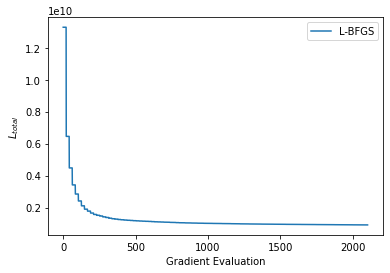

In [51]:
plt.plot(loss_history)
plt.legend(['L-BFGS'])
plt.ylabel('$L_{total}$')
plt.xlabel('Gradient Evaluation')

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

Ajustando la combinación de pesos de las losses se balancea la reconstrucción de contenido, la transferencia de estilo, y la reducción de ruido (ruido de alta frecuencia = pixelado) en la imagen sintetizada (imagen de salida).

Estos pesos (α para el contenido, β para el estilo y TVW para Total Variation Loss) son, por lo tanto, hiperparámetros.

Si la relacion de α/β (contenido/estilo) es pequeña, se pone mayor énfasis en el estilo (imagen que aporta el estilo) y la imagen generada se parecerá más a la de estilo...y al revés se pone más énfasis en el contenido (imagen que aporta el contenido). Es decir, cuánto de la imagen que aporta el estilo (texturas, colores, curvaturas, etc) aparecerá en la imagen de salida...y cuánto de la imagen que aporta el contenido aparecerá en la imagen de salida.

La "Total Variation Loss" actúa como un término de regularización, operando sobre los pixeles de la imagen generada para lograr una imagen más suavizada aunque afectando un poco sy nitidez.

Nota:
En la carpeta "/content/Pregunta 8" del repositorio están las imágenes finales generadas (resultado después de 100 iteraciones) a partir de las imágenes originales de la notebook para diferentes combinaciones de pesos de las losses.
En el nombre de archivo de cada imagen se indican los valores de los pesos de losses utilizados para generar dicha imagen. Por ejemplo, "pto8_alfa1_beta10000_TVL1e-1__xxxxxxx" significa que se usó un alfa (contenido) de 1, un beta (estilo) de 10000 y un peso para Total Variation Loss de 0.1


# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

En la carpeta "/content/Pregunta 9" están las imágenes finales generadas (resultado después de 100 iteraciones) a partir de imágenes elegidas para algunas combinaciones de pesos de las losses.
Los archivos "Mama_Miro__output_at_iteration_99.png" y "Mama_Picasso__output_at_iteration_99.png" son las imágenes resultantes (luego de 100 iteraciones) utilizando como imagen de contenido "Mama.jpg" y como imagen de estilo "Miro_set-52.jpg" y "Pablo_Picasso_92.jpg".